In [1]:
import os
import shutil
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
def create_pca_dataset(src_root, dest_root, limit=1000):
    subfolders = ['train', 'validation']
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    image_extensions = ['.jpg', '.png']

    if not os.path.exists(dest_root):
        os.makedirs(dest_root)

    images = []

    for subfolder in subfolders:
        for emotion in emotions:
            folder_path = os.path.join(src_root, subfolder, emotion)
            for file in os.listdir(folder_path):
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    images.append(os.path.join(folder_path, file))

    random.shuffle(images)
    selected_images = images[:limit]

    for idx, img_path in enumerate(selected_images):
        dest_path = os.path.join(dest_root, f"{idx+1:04d}.jpg")
        shutil.copy(img_path, dest_path)

    print(f"Dataset created at: {dest_root} with {len(selected_images)} images.")

class GrayscaleFaceDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (48, 48))  # Ensure consistent image size
        return image.flatten()

### Explanation of the Mean Image

1. **Pixel-wise Averaging**:  
   The mean image is computed by taking the average of each pixel location across all images in the dataset. For example, if you have \( N \) images of size \( H \times W \), the mean image \( M \) is calculated as:  
   $$
   M_{i,j} = \frac{1}{N} \sum_{k=1}^{N} I_{k,i,j}
   $$  
   where:

   I_{k,i,j} is the pixel value at location (i,j) in the k-th image. This results in a single image where each pixel represents the average intensity at that location across all images.

2. **Central Tendency of the Dataset**:
   The mean image serves as a statistical summary of the dataset, capturing the most common pixel values across all images. It highlights patterns or features that are consistently present (e.g., cheeks, mouth, eyes, eyebrows, hair) while ignoring any deviation. Mathematically, it minimizes the sum of squared differences between itself and all images in the dataset.

---

In short, the mean image is a straightforward, mathematical aggregation of pixel values that provides a compact representation of the dataset's **MOST DOMINANT FACE PATTERN**.

## Why Compute the Covariance Matrix with Respect to the Smallest Dimension?

When computing the Empirical Covariance matrix for PCA, the standard approach is:

$$
C = \frac{1}{n} J^T J
$$

where:
- \( J \) is the mean-centered data matrix (each row is an image).
- \( n \) is the number of images.

The covariance matrix \( C \) has dimensions DxD, where D is the dimensionality of each image (e.g., 2304 for a 48x48).


1. **Memory Efficiency**:
   - The `JJᵀ` matrix is much smaller (`2,304 × 2,304`) compared to `JᵀJ` (`28,821 × 28,821`), making `JᵀJ` significantly more memory-efficient when `D ≪ n`.

2. **Computational Efficiency**:
   - Computing `JᵀJ` is computationally more efficient when `D ≪ n`, as the resulting matrix is smaller and requires less time to process.

In [3]:
def perform_pca(data, n_components):
    mean_image = np.mean(data, axis=0)
    centered_data = data - mean_image
    covariance_matrix = np.cov(centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    if n_components > eigenvectors.shape[1]:
        raise ValueError("n_components cannot be greater than the number of features.")
    top_eigenvectors = eigenvectors[:, :n_components]
    transformed_data = np.dot(centered_data, top_eigenvectors)
    return mean_image, eigenvalues, top_eigenvectors, transformed_data

def explained_variance_ratio(eigenvalues):
    total_variance = np.sum(eigenvalues)
    return eigenvalues / total_variance

def binary_search_limit(eigenvalues, target_variance_ratio):
    explained_ratios = explained_variance_ratio(eigenvalues)
    cumulative_variance = np.cumsum(explained_ratios)
    left = 1
    right = len(eigenvalues)
    best_limit = right
    while left <= right:
        mid = (left + right) // 2
        current_variance = cumulative_variance[mid - 1]
        if current_variance >= target_variance_ratio:
            best_limit = mid
            right = mid - 1
        else:
            left = mid + 1
    return best_limit

def visualize_pca_results(mean_image, eigenvectors, image_shape, n_components):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, n_components + 1, 1)
    plt.imshow(mean_image.reshape(image_shape), cmap='gray')
    plt.title("Mean Image")
    plt.axis('off')
    for i in range(n_components):
        plt.subplot(1, n_components + 1, i + 2)
        plt.imshow(eigenvectors[:, i].reshape(image_shape), cmap='gray')
        plt.title(f"Eigenface {i+1}")
        plt.axis('off')
    plt.show()

def train_and_predict_pca_classifier(transformed_data, labels, test_samples, pca_eigenvectors, mean_image):
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, labels, test_size=0.2, random_state=42)
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    print(f"Classifier Accuracy: {accuracy_score(y_test, predictions)}")
    
    centered_test_samples = test_samples - mean_image
    transformed_test_samples = np.dot(centered_test_samples, pca_eigenvectors)
    test_predictions = classifier.predict(transformed_test_samples)
    return test_predictions

Dataset created at: /kaggle/working/pca_faces with 1000 images.
Optimal number of components for 99.0% variance: 463


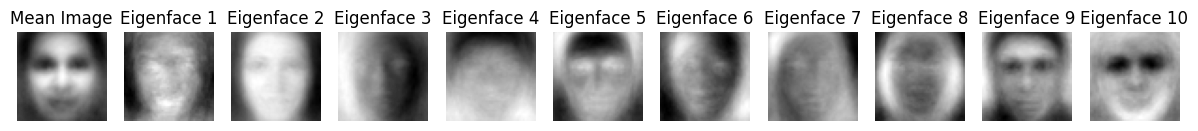

100%|██████████| 170M/170M [00:03<00:00, 49.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Classifier Accuracy: 0.975
Test Accuracy on 1000 Images: 0.994


In [4]:
from torchvision import datasets, transforms

def load_cifar10_data():
    transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((48, 48)),  # Resize to match face data size
        transforms.ToTensor(),  # Convert to tensor
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
    ])
    dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    images, _ = next(iter(dataloader))  # We don't need CIFAR-10 labels
    return images.numpy()
from sklearn.preprocessing import StandardScaler

def train_and_predict_pca_classifier(transformed_data, labels, test_samples, pca_eigenvectors, mean_image):
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, labels, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    classifier = LogisticRegression(max_iter=1000, solver='lbfgs') 
    classifier.fit(X_train, y_train)
    
    predictions = classifier.predict(X_test)
    print(f"Classifier Accuracy: {accuracy_score(y_test, predictions)}")
    
    centered_test_samples = test_samples - mean_image
    transformed_test_samples = np.dot(centered_test_samples, pca_eigenvectors)
    transformed_test_samples = scaler.transform(transformed_test_samples) 
    
    test_predictions = classifier.predict(transformed_test_samples)
    return test_predictions

if __name__ == "__main__":
    
    src_root = '/kaggle/input/face-expression-recognition-dataset/images'
    dest_root = '/kaggle/working/pca_faces'
    limit = 1000

    create_pca_dataset(src_root, dest_root, limit)

    image_shape = (48, 48)
    dataset = GrayscaleFaceDataset(dest_root)
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    all_images = next(iter(dataloader)).numpy()

    n_components = 10
    target_variance_ratio = 0.99

    mean_image, eigenvalues, _, _ = perform_pca(all_images, len(all_images[0]))
    optimal_limit = binary_search_limit(eigenvalues, target_variance_ratio)
    print(f"Optimal number of components for {target_variance_ratio*100}% variance: {optimal_limit}")

    mean_image, eigenvalues, eigenvectors, transformed_data = perform_pca(all_images, optimal_limit)
    visualize_pca_results(mean_image, eigenvectors, image_shape, n_components)

    def prepare_labels_and_samples(face_data, no_face_data):
        face_labels = np.ones(len(face_data))
        no_face_labels = np.zeros(len(no_face_data))  # 0 for no-face
        combined_data = np.vstack((face_data, no_face_data))
        combined_labels = np.hstack((face_labels, no_face_labels))
        return combined_data, combined_labels

    cifar10_data = load_cifar10_data()

    combined_data, combined_labels = prepare_labels_and_samples(all_images, cifar10_data[:len(all_images)])  # Use same number of no-face images as face images

    mean_image_combined, eigenvalues_combined, eigenvectors_combined, transformed_data_combined = perform_pca(combined_data, optimal_limit)

    test_face_samples = all_images[:500] 
    test_no_face_samples = cifar10_data[500:1000] 
    test_samples = np.vstack((test_face_samples, test_no_face_samples))

    predictions = train_and_predict_pca_classifier(transformed_data_combined, combined_labels, test_samples, eigenvectors_combined, mean_image_combined)

    test_labels = np.hstack((np.ones(500), np.zeros(500))) 
    test_accuracy = accuracy_score(test_labels, predictions)
    print(f"Test Accuracy on 1000 Images: {test_accuracy}")